In [1]:
from helper_functions import *
import h5py
import numpy as np
from scipy.misc import imresize
import random
from random import randint
import pickle
from skimage import data
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

%matplotlib inline

## 1. Download and extract the data

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
folder = '../data/SVHN_data/'
train = 'train.tar.gz'
test = 'test.tar.gz'
extra = 'extra.tar.gz'

train = maybe_download(url, folder, train, 404141560)
test = maybe_download(url, folder, test, 276555967)
extra = maybe_download(url, folder, extra, 1955489752)

('Found and verified', 'train.tar.gz')
('Found and verified', 'test.tar.gz')
('Found and verified', 'extra.tar.gz')


In [3]:
train_folder = maybe_extract(folder, train)
test_folder = maybe_extract(folder, test)
extra_folder = maybe_extract(folder, extra)

../data/SVHN_data/train already present - Skipping extraction of ../data/SVHN_data/train.tar.gz.
../data/SVHN_data/test already present - Skipping extraction of ../data/SVHN_data/test.tar.gz.
../data/SVHN_data/extra already present - Skipping extraction of ../data/SVHN_data/extra.tar.gz.


In [4]:
N = 6

def get_attr(c, i, attr):
    d = c[c['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    if d.dtype == 'float64':
        return d.reshape(-1)
    return np.array([c[x].value for x in d]).squeeze()

def load_data(path):
    c = h5py.File(path)
    images = a = np.ndarray(shape=(c['digitStruct']['name'].shape[0], ), dtype='|S15')
    labels = np.zeros((len(c['digitStruct']['bbox']), N+1), dtype=float)
    labels.fill(10)
    
    lefts   = np.zeros((len(c['digitStruct']['bbox']), N), dtype=float)
    tops    = np.zeros((len(c['digitStruct']['bbox']), N), dtype=float)
    rights  = np.zeros((len(c['digitStruct']['bbox']), N), dtype=float) 
    bottoms = np.zeros((len(c['digitStruct']['bbox']), N), dtype=float)
    
    for i in xrange(c['digitStruct']['name'].shape[0]):
        images[i] = c[c['digitStruct']['name'][i][0]].value.tostring().replace('\x00', '')
        label = get_attr(c, i, 'label')
        
        left = get_attr(c, i, 'left')
        top = get_attr(c, i, 'top')
        right = get_attr(c, i, 'left') + get_attr(c, i, 'width')
        bottom = get_attr(c, i, 'top') + get_attr(c, i, 'height')
               
        labels[i, 0] = label.shape[0]
        labels[i, 1:label.shape[0]+1] = label
        
        lefts[i, :left.shape[0]] = left
        tops[i, :top.shape[0]] = top
        rights[i, :right.shape[0]] = right
        bottoms[i, :bottom.shape[0]] = bottom
    
    return labels, images, lefts, tops, rights, bottoms

In [5]:
train_tuple = load_data(folder+'train/digitStruct.mat')
test_tuple = load_data(folder+'test/digitStruct.mat')
extra_tuple = load_data(folder+'extra/digitStruct.mat')

### 1.1. Some data exploration

In [6]:
a = [int(x[0]) for x in train_tuple[0]]
width = [a_i - b_i for a_i, b_i in zip([x for x in train_tuple[4]],[x for x in train_tuple[2]])]
height = [a_i - b_i for a_i, b_i in zip([x for x in train_tuple[5]],[x for x in train_tuple[3]])]

for i in range(len(width)):
    width[i] = width[i][0:a[i]]
    height[i] = height[i][0:a[i]]

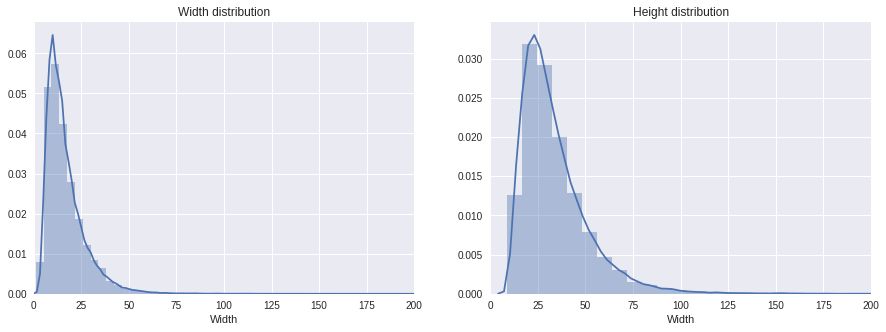

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(np.concatenate(width))
plt.title("Width distribution")
plt.xlabel("Width")
plt.xlim(0,200)

plt.subplot(1, 2, 2)
sns.distplot(np.concatenate(height))
plt.title("Height distribution")
plt.xlabel("Width")
plt.xlim(0,200)

plt.savefig('../images/width_height_dist.png')

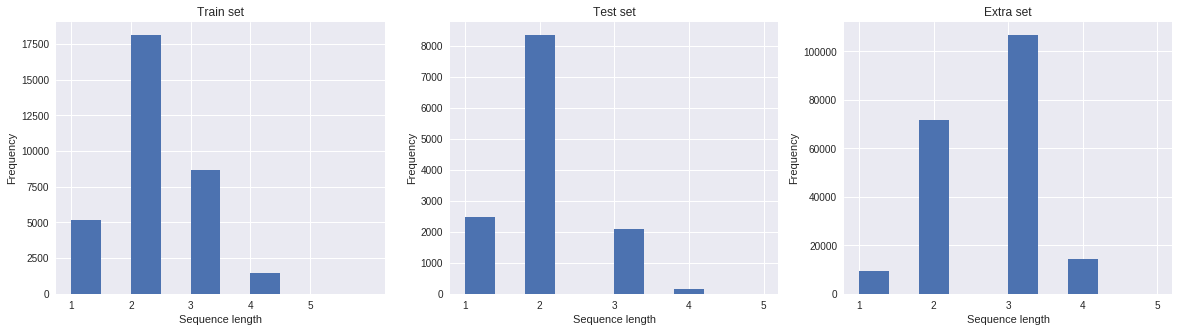

In [8]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist([int(x[0]) for x in train_tuple[0]])
plt.xticks([1,2,3,4,5])
plt.title("Train set")
plt.xlabel("Sequence length")
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist([int(x[0]) for x in test_tuple[0]])
plt.xticks([1,2,3,4,5])
plt.title("Test set")
plt.xlabel("Sequence length")
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist([int(x[0]) for x in extra_tuple[0]])
plt.xticks([1,2,3,4,5])
plt.title("Extra set")
plt.xlabel("Sequence length")
plt.ylabel('Frequency')

plt.savefig('../images/sequence_length_freq.png')

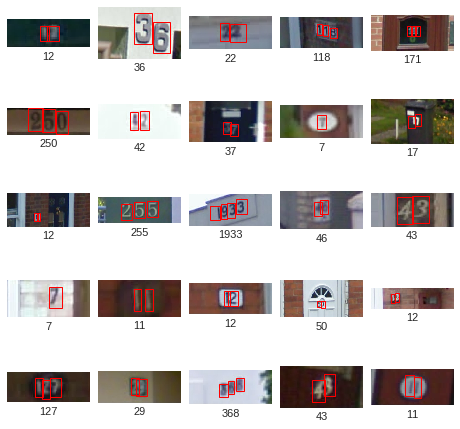

In [9]:
num_images = test_tuple[0].shape[0]
rand_list = random.sample(range(1, num_images), 25)

images = [[]]*len(rand_list)
lables = [[]]*len(rand_list)
lefts = [[]]*len(rand_list)
bottoms = [[]]*len(rand_list)
widths = [[]]*len(rand_list)
heights = [[]]*len(rand_list)
tops = [[]]*len(rand_list)

for i in range(len(rand_list)):
    img_name =  [x[rand_list[i]] for x in test_tuple][1]
    lable = [int(y) for y in [x[rand_list[i]] for x in test_tuple][0]]
    
    left = [int(y) for y in [x[rand_list[i]] for x in test_tuple][2]][0:lable[0]]
    top = [int(y) for y in [x[rand_list[i]] for x in test_tuple][3]][0:lable[0]]
    right = [int(y) for y in [x[rand_list[i]] for x in test_tuple][4]][0:lable[0]]
    bottom = [int(y) for y in [x[rand_list[i]] for x in test_tuple][5]][0:lable[0]]
    width = [a_i - b_i for a_i, b_i in zip(right, left)]
    height = [a_i - b_i for a_i, b_i in zip(bottom, top)]
    
    images[i] = Image.open(folder + 'test/'+ img_name)
    lables[i] = ''.join([str(0 if x==10 else x) for x in lable[1:lable[0]+1]])
    
    lefts[i] = left
    bottoms[i] = bottom
    widths[i] = width
    heights[i] = height
    tops[i] = top

fig, axes = plt.subplots(5,5,figsize=(8,8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    for e in range(len(bottoms[i])):
        rect = patches.Rectangle((lefts[i][e],tops[i][e]),widths[i][e],heights[i][e],
                                 linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel = "{0}".format(lables[i])
    ax.set_xlabel(xlabel)
    
plt.savefig('../images/svhn_examples.png')

## 2. Reformat the data + greyscale

In [10]:
IMAGE_SIZE = 48
NUM_CHANNELS = 1

def reformat_images(data_tuple, data):
    
    num_images = data_tuple[0].shape[0]
    images = [[]]*num_images
    
    for a in range(num_images):
        i =  [x[a] for x in data_tuple]
        L =  int(i[0][0])
        image = Image.open(folder + data+'/'+ i[1])
        
        left = [x for x in i[2]][0:L]
        top = [x for x in i[3]][0:L]
        right = [x for x in i[4]][0:L]
        bottom = [x for x in i[5]][0:L]
        
        width = [a_i - b_i for a_i, b_i in zip(right, left)]
        height = [a_i - b_i for a_i, b_i in zip(bottom, top)]
        
        
        img_min_top = np.amin(top)
        img_min_left = np.amin(left)
        img_height = np.amax(top) + height[np.argmax(top)] - img_min_top
        img_width = np.amax(left) + width[np.argmax(left)] - img_min_left

        img_left = np.floor(img_min_left - 0.1 * img_width)
        img_top = np.floor(img_min_top - 0.1 * img_height)
        img_right = np.amin([np.ceil(img_left + 1.2 * img_width), image.size[0]])
        img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), image.size[1]])
            
        image = image.crop((img_left, img_top, img_right, img_bottom)).\
        resize([IMAGE_SIZE, IMAGE_SIZE], Image.ANTIALIAS)
              
        
        image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) 
        mean = np.mean(image, dtype='float32')
        std = np.std(image, dtype='float32', ddof=1)
        if std < 0.0001: 
            std = 1.0
        image = (image - mean) / std
        image = image.reshape((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
    
        images[a] = image
    return np.array(images)

In [32]:
def get_metadata(input_tuple):
    metadata = [[]]*len(input_tuple[1])
    for i in range(len(metadata)):
        metadata[i] = ([x[i] for x in input_tuple][2],
                       [x[i] for x in input_tuple][3],
                       [x[i] for x in input_tuple][4],
                       [x[i] for x in input_tuple][5])
    return metadata

In [49]:
train_dataset = reformat_images(train_tuple, 'train')
train_labels = train_tuple[0].astype(int)
train_images = train_tuple[1]
train_metadata = get_metadata(train_tuple)

test_dataset = reformat_images(test_tuple, 'test')
test_labels = test_tuple[0].astype(int)
test_images = test_tuple[1]
test_metadata = get_metadata(test_tuple)

extra_dataset = reformat_images(extra_tuple, 'extra')
extra_labels = extra_tuple[0].astype(int)
extra_images = extra_tuple[1]
extra_metadata = get_metadata(extra_tuple)

## How this works: example

In [60]:
img_name =  test_images[1]
lable = test_labels[1]
left = test_metadata[1][0][0:lable[0]]
top = test_metadata[1][1][0:lable[0]]
right = test_metadata[1][2][0:lable[0]]
bottom = test_metadata[1][3][0:lable[0]]
width = [a_i - b_i for a_i, b_i in zip(right, left)]
height = [a_i - b_i for a_i, b_i in zip(bottom, top)]

img_min_top = np.amin(top)
img_min_left = np.amin(left)
img_height = np.amax(top) + height[np.argmax(top)] - img_min_top
img_width = np.amax(left) + width[np.argmax(left)] - img_min_left

image = Image.open(folder + 'test/'+ img_name)

img_left = np.floor(img_min_left - 0.1 * img_width)
img_top = np.floor(img_min_top - 0.1 * img_height)
img_right = np.amin([np.ceil(img_left + 1.2 * img_width), image.size[0]])
img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), image.size[1]]) 

lable = ''.join([str(0 if x==10 else x) for x in lable[1:lable[0]+1]])

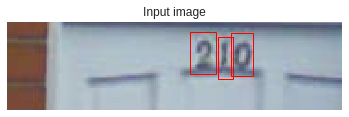

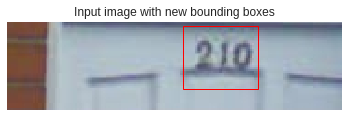

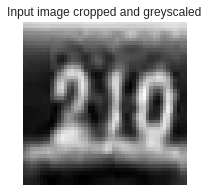

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image)
for e in range(len(bottom)):
    rect = patches.Rectangle((left[e],top[e]),width[e],height[e],
                                 linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
ax.set_xticks([])
ax.set_yticks([])
plt.title("Input image")

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image)
rect = patches.Rectangle((img_left,img_top),img_right-img_left,img_bottom,
                                 linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
    
ax.set_xticks([])
ax.set_yticks([])
plt.title("Input image with new bounding boxes")

fig, ax = plt.subplots(figsize=(3, 3))
images = test_dataset[1,:,:,:]
ax.imshow(images.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
ax.set_xticks([])
ax.set_yticks([])
plt.title("Input image cropped and greyscaled")

plt.savefig('../images/data_transformation_example.png')

### 2.1. Splt train - valid:

In [62]:
train_dataset, valid_dataset, train_labels, valid_labels, train_images, valid_images,\
train_metadata, valid_metadata= \
train_test_split(train_dataset, train_labels, train_images, train_metadata, test_size=0.15, random_state=42)

In [63]:
extra_to_use_dataset, extra_dataset, extra_to_use_labels, extra_labels, extra_to_use_images, extra_images,\
extra_to_use_metadata, extra_metadata= \
train_test_split(extra_dataset, extra_labels, extra_images, extra_metadata, test_size=0.6, random_state=42)

extra_train_dataset, extra_test_dataset, extra_train_labels, extra_test_labels,\
extra_train_images, extra_test_images, extra_train_metadata, extra_test_metadata = \
train_test_split(extra_to_use_dataset, extra_to_use_labels, extra_to_use_images, extra_to_use_metadata,\
                 test_size=0.2, random_state=42)

extra_train_dataset, extra_valid_dataset, extra_train_labels, extra_valid_labels,\
extra_train_images, extra_valid_images, extra_train_metadata, extra_valid_metadata= \
train_test_split(extra_train_dataset, extra_train_labels, extra_train_images, extra_train_metadata,\
                 test_size=0.15, random_state=42)

In [64]:
train_dataset = np.append(train_dataset, extra_train_dataset, axis=0)
train_labels = np.append(train_labels, extra_train_labels, axis=0)
train_images = np.append(train_images, extra_train_images, axis=0)
train_metadata = np.append(train_metadata, extra_train_metadata, axis=0)

test_dataset = np.append(test_dataset, extra_test_dataset, axis=0)
test_labels = np.append(test_labels, extra_test_labels, axis=0)
test_images = np.append(test_images, extra_test_images, axis=0)
test_metadata = np.append(test_metadata, extra_test_metadata, axis=0)

valid_dataset = np.append(valid_dataset, extra_valid_dataset, axis=0)
valid_labels = np.append(valid_labels, extra_valid_labels, axis=0)
valid_images = np.append(valid_images, extra_valid_images, axis=0)
valid_metadata = np.append(valid_metadata, extra_valid_metadata, axis=0)

### 2.2 Correct for length

In [65]:
## remove elements with length 6:

train_dataset = train_dataset[[e for e,y in enumerate(train_labels) if y[0]<=5],:]
train_labels = train_labels[[e for e,y in enumerate(train_labels) if y[0]<=5],:]
train_images = train_images[[e for e,y in enumerate(train_labels) if y[0]<=5],]

valid_dataset = valid_dataset[[e for e,y in enumerate(valid_labels) if y[0]<=5],:]
valid_labels = valid_labels[[e for e,y in enumerate(valid_labels) if y[0]<=5],:]
valid_images = valid_images[[e for e,y in enumerate(valid_labels) if y[0]<=5],]

test_dataset = test_dataset[[e for e,y in enumerate(test_labels) if y[0]<=5],:]
test_labels = test_labels[[e for e,y in enumerate(test_labels) if y[0]<=5],:]
test_images = test_images[[e for e,y in enumerate(test_labels) if y[0]<=5],]

extra_dataset = extra_dataset[[e for e,y in enumerate(extra_labels) if y[0]<=5],:]
extra_labels = extra_labels[[e for e,y in enumerate(extra_labels) if y[0]<=5],:]
extra_images = extra_images[[e for e,y in enumerate(extra_labels) if y[0]<=5],]

train_labels = np.array([x[0:6] for x in train_labels])
valid_labels = np.array([x[0:6] for x in valid_labels])
test_labels = np.array([x[0:6] for x in test_labels])
extra_labels = np.array([x[0:6] for x in extra_labels])

### 2.3. Correct labels

In [66]:
def label_zero(labels):
    for label in labels:
    #print(label)
        L = label[0]
        for i in range(1,L+1):
            if label[i] == 10:
                label[i] = 0
    return labels

In [67]:
train_labels = label_zero(train_labels)
test_labels = label_zero(test_labels)
extra_labels = label_zero(extra_labels)
valid_labels = label_zero(valid_labels)

In [68]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (83429, 48, 48, 1), (83429, 6))
('Validation set', (14724, 48, 48, 1), (14724, 6))
('Test set', (29257, 48, 48, 1), (29257, 6))


## 3. Take a look at generated sequences

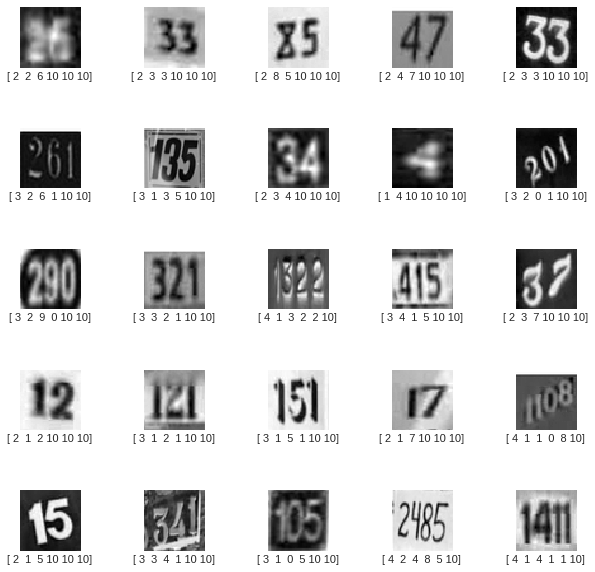

In [69]:
rand_list = random.sample(range(1, train_dataset.shape[0]), 25)
images = train_dataset[rand_list,:,:,:]

fig, axes = plt.subplots(5,5,figsize=(10, 10))
fig.subplots_adjust(hspace=1, wspace=1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel=train_labels[rand_list[i]]
    ax.set_xlabel(xlabel)

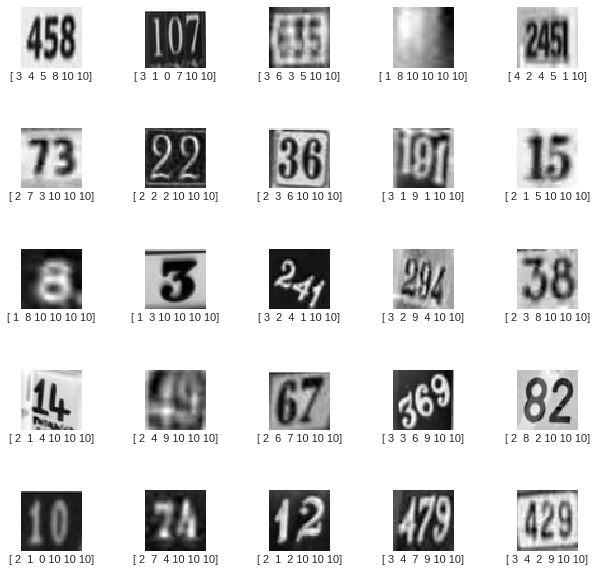

In [70]:
rand_list = random.sample(range(1, valid_dataset.shape[0]), 25)
images = valid_dataset[rand_list,:,:,:]

fig, axes = plt.subplots(5,5,figsize=(10, 10))
fig.subplots_adjust(hspace=1, wspace=1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel=valid_labels[rand_list[i]]
    ax.set_xlabel(xlabel)

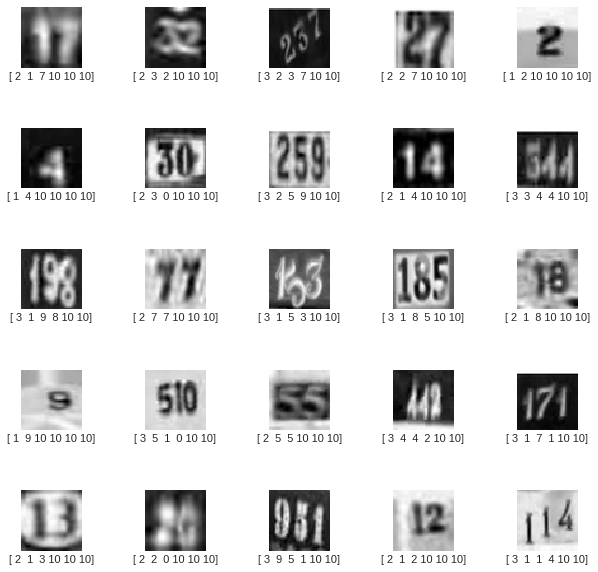

In [71]:
rand_list = random.sample(range(1, test_dataset.shape[0]), 25)
images = test_dataset[rand_list,:,:,:]

fig, axes = plt.subplots(5,5,figsize=(10, 10))
fig.subplots_adjust(hspace=1, wspace=1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel=test_labels[rand_list[i]]
    ax.set_xlabel(xlabel)

## 4. Pickle

In [72]:
svhn_seq = dict()
svhn_seq["train_dataset"] = train_dataset
svhn_seq["train_labels"]  = train_labels
svhn_seq["train_images"]  = train_images
svhn_seq["train_metadata"]  = train_metadata

svhn_seq["test_dataset"]  = test_dataset
svhn_seq["test_labels"]   = test_labels
svhn_seq["test_images"]   = test_images
svhn_seq["test_metadata"]  = test_metadata

svhn_seq["valid_dataset"] = valid_dataset
svhn_seq["valid_labels"]  = valid_labels
svhn_seq["valid_images"]  = valid_images
svhn_seq["valid_metadata"]  = valid_metadata

svhn_seq["extra_dataset"] = extra_dataset
svhn_seq["extra_labels"]  = extra_labels
svhn_seq["extra_images"]  = extra_images
svhn_seq["extra_metadata"]  = extra_metadata

In [73]:
fileObject = open('../pickles/svhn_seq','wb') 
pickle.dump(svhn_seq,fileObject)   
fileObject.close()